## Notebook setup

In [1]:
import os
import io
import sys
import warnings
import datetime
import numpy as np
import base64
import dotenv

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import openai

# Get the current InteractiveShell instance
#ipython = get_ipython()

# Run a shell command
#result = ipython.getoutput("ls -l")

# Print the output
#print(result)

from IPython.display import HTML

from openbb_terminal.reports import widget_helpers as widgets
from openbb_terminal.sdk import openbb
from openbb_terminal import config_terminal as cfg
from openbb_terminal.helper_classes import TerminalStyle
from openbb_terminal.core.config.paths import USER_ENV_FILE, REPOSITORY_DIRECTORY
import yfinance as yf
import pandas as pd
from dhelp import color_dataframe, get_investor_report_url_dict,get_morningstar_report_url_dict, get_exchange_dict,get_similar_companies_dict, display_historical_metric
from jinja2 import Template

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")
warnings.filterwarnings("ignore")

# Detect if prediction capabilities are present. If they are not, disable prediction in the rest of the script
# so that the report can still be generated without prediction results.
# predictions = True
# try:
#     openbb.stocks.pred.models
# except Exception as e:
#     predictions = False

# TODO Fix predictions virtual path on api refactored

predictions = False

In [2]:
cfg.theme = TerminalStyle("light", "light", "light")

stylesheet = widgets.html_report_stylesheet()

## Select symbol

In [3]:
# Parameters that will be replaced when calling this notebook
# Do not leave parameters blank as notebook will not run otherwise
#symbol = sys.argv[1]
symbol = "FLNG"

investor_report_url_dict= get_investor_report_url_dict()
morningstar_report_url_dict=get_morningstar_report_url_dict()
exchange_dict=get_exchange_dict()
similar_companies_dict=get_similar_companies_dict()

if (symbol in investor_report_url_dict):
    investor_report_url = investor_report_url_dict[symbol]
else:
    investor_report_url=""

if (symbol in morningstar_report_url_dict):
    morningstar_report_url = morningstar_report_url_dict[symbol]
else:
    morningstar_report_url= ""

df_data = openbb.stocks.fa.data(symbol)
long_name = df_data.at["Company","Values"]
sector =  df_data.at["Sector","Values"]
industry = df_data.at["Industry","Values"]

if (symbol in exchange_dict):
    exchange=exchange_dict[symbol]
else:
    exchange = "NYSE"

report_name = f"{symbol}".upper()

In [4]:
if "." in symbol:
    import sys

    sys.exit(0)
symbol = symbol.upper()

In [5]:
ticker_data = openbb.stocks.load(
    symbol=symbol, start_date=datetime.datetime.now() - datetime.timedelta(days=18 * 30)
)
ticker_data = openbb.stocks.process_candle(data=ticker_data)

author = ""
report_title = f"Investment Research Report on {symbol.upper()}"
report_date = datetime.datetime.now().strftime("%d %B, %Y")
report_time = datetime.datetime.now().strftime("%H:%M")
report_timezone = datetime.datetime.now(datetime.timezone.utc).astimezone().tzinfo
report_title, report_date, report_time, report_timezone

Loading Daily data for EGY with starting period 2021-10-18.

('Investment Research Report on EGY',
 '09 April, 2023',
 '18:37',
 datetime.timezone(datetime.timedelta(days=-1, seconds=72000), 'Eastern Daylight Time'))

## Data

In [6]:
(
    df_year_estimates,
    df_quarter_earnings,
    df_quarter_revenues,
) = openbb.stocks.dd.est(symbol=symbol)
df_quarter_revenues
color_dataframe(df_quarter_revenues)

,,Previous Quarter,Current Quarter,Next Quarter,Current Year,Next Year
Date,-,-,-,-,-,-
No. of analysts,-,-,-,-,-,-
Average estimate,-,-,-,-,-,-
Year ago,-,-,-,-,97.80,6.72
Publish date,5.09,3.60,3.09,2.89,2.86,2.50


In [7]:
display_year = sorted(df_year_estimates.columns.tolist())[:3]
df_year_estimates = df_year_estimates[display_year].head(5)
df_year_estimates

,2023,2024,2025
YEARLY ESTIMATES,,,
Revenue,-,-,-
Dividend,-,-,-
Dividend Yield (in %),5.99 %,6.14 %,6.27 %
EPS,-,-,-
P/E Ratio,2.66,3.79,3.08


In [8]:
tables = openbb.etf.news(f"{long_name}", 20)
for table in tables:
    table[0].loc["link"] = (
        table[0].loc["link"].apply(lambda x: f'<a href="{x}">{x}</a>')
    )

11 news articles for  VAALCO Energy, Inc. were found since 2023-04-02

In [9]:
df_institutional_shareholders = openbb.stocks.fa.shrs(symbol, holder="institutional")
df_institutional_shareholders.index += 1
df_institutional_shareholders

,Holder,Shares,Date Reported,Stake,Value
1,State Street Corporation,7.279 M,2022-12-30,6.72 %,32.319 M
2,Blackrock Inc.,7.209 M,2022-12-30,6.65 %,32.008 M
3,"Vanguard Group, Inc. (The)",5.818 M,2022-12-30,5.37 %,25.833 M
4,"Renaissance Technologies, LLC",2.701 M,2022-12-30,2.49 %,11.993 M
5,Invesco Ltd.,2.286 M,2022-12-30,2.11 %,10.151 M
6,"Geode Capital Management, LLC",1.882 M,2022-12-30,1.74 %,8.356 M
7,"Tieton Capital Management, LLC",1.716 M,2022-12-30,1.58 %,7.618 M
8,First Sabrepoint Capital Management LP,1.650 M,2022-12-30,1.52 %,7.326 M
9,Kornitzer Capital Management Inc /ks,1.606 M,2022-12-30,1.48 %,7.129 M
10,Bank Of New York Mellon Corporation,1.241 M,2022-12-30,1.14 %,5.508 M


In [10]:
openbb.stocks.fa.shrs(symbol)

,Holder,Shares,Date Reported,Stake,Value
0,State Street Corporation,7.279 M,2022-12-30,6.72 %,32.319 M
1,Blackrock Inc.,7.209 M,2022-12-30,6.65 %,32.008 M
2,"Vanguard Group, Inc. (The)",5.818 M,2022-12-30,5.37 %,25.833 M
3,"Renaissance Technologies, LLC",2.701 M,2022-12-30,2.49 %,11.993 M
4,Invesco Ltd.,2.286 M,2022-12-30,2.11 %,10.151 M
5,"Geode Capital Management, LLC",1.882 M,2022-12-30,1.74 %,8.356 M
6,"Tieton Capital Management, LLC",1.716 M,2022-12-30,1.58 %,7.618 M
7,First Sabrepoint Capital Management LP,1.650 M,2022-12-30,1.52 %,7.326 M
8,Kornitzer Capital Management Inc /ks,1.606 M,2022-12-30,1.48 %,7.129 M
9,Bank Of New York Mellon Corporation,1.241 M,2022-12-30,1.14 %,5.508 M


In [11]:
#fig, ax = plt.subplots(figsize=(11,5), dpi=150)
#dhelp.display_historical_metric([symbol],"OSS", external_axes=[
#        ax,
#    ])

#fig.tight_layout()
#f = io.BytesIO()
#fig.savefig(f, format="svg")
#shares_outstanding_chart = f.getvalue().decode("utf-8")

In [12]:
df_institutional_shareholders = openbb.stocks.fa.shrs(symbol)
df_institutional_shareholders.index += 1
df_institutional_shareholders

,Holder,Shares,Date Reported,Stake,Value
1,State Street Corporation,7.279 M,2022-12-30,6.72 %,32.319 M
2,Blackrock Inc.,7.209 M,2022-12-30,6.65 %,32.008 M
3,"Vanguard Group, Inc. (The)",5.818 M,2022-12-30,5.37 %,25.833 M
4,"Renaissance Technologies, LLC",2.701 M,2022-12-30,2.49 %,11.993 M
5,Invesco Ltd.,2.286 M,2022-12-30,2.11 %,10.151 M
6,"Geode Capital Management, LLC",1.882 M,2022-12-30,1.74 %,8.356 M
7,"Tieton Capital Management, LLC",1.716 M,2022-12-30,1.58 %,7.618 M
8,First Sabrepoint Capital Management LP,1.650 M,2022-12-30,1.52 %,7.326 M
9,Kornitzer Capital Management Inc /ks,1.606 M,2022-12-30,1.48 %,7.129 M
10,Bank Of New York Mellon Corporation,1.241 M,2022-12-30,1.14 %,5.508 M


In [13]:
df_sec_filings = openbb.stocks.dd.sec(symbol=symbol)
if (len(df_sec_filings) > 0):
    df_sec_filings = df_sec_filings[["Type", "Category", "Link"]].head(
        5
    )
    df_sec_filings["Link"] = df_sec_filings["Link"].apply(
        lambda x: f'<a href="{x}">{x}</a>'
    )
df_sec_filings

,Type,Category,Link
Filing Date,,,
04/07/2023,8-K,Special Events,"<a href=""https://www.marketwatch.com/investing/stock/egy/financials/secfilings?docid=16552609"">https://www.marketwatch.com/investing/stock/egy/financials/secfilings?docid=16552609</a>"
04/06/2023,10-K,Annual Reports,"<a href=""https://www.marketwatch.com/investing/stock/egy/financials/secfilings?docid=16552175"">https://www.marketwatch.com/investing/stock/egy/financials/secfilings?docid=16552175</a>"
04/06/2023,8-K,Special Events,"<a href=""https://www.marketwatch.com/investing/stock/egy/financials/secfilings?docid=16549554"">https://www.marketwatch.com/investing/stock/egy/financials/secfilings?docid=16549554</a>"
03/31/2023,8-K,Special Events,"<a href=""https://www.marketwatch.com/investing/stock/egy/financials/secfilings?docid=16534136"">https://www.marketwatch.com/investing/stock/egy/financials/secfilings?docid=16534136</a>"
03/10/2023,8-K,Special Events,"<a href=""https://www.marketwatch.com/investing/stock/egy/financials/secfilings?docid=16481581"">https://www.marketwatch.com/investing/stock/egy/financials/secfilings?docid=16481581</a>"


In [14]:
df_analyst = openbb.stocks.dd.analyst(symbol=symbol)

In [15]:
df_rating = openbb.stocks.dd.rating(symbol)
df_rating

,Rating,DCF,ROE,ROA,DE,PE,PB
date,,,,,,,
2023-03-31,Strong Buy,Strong Buy,Neutral,Neutral,Buy,Strong Buy,Strong Buy
2023-03-30,Strong Buy,Strong Buy,Neutral,Neutral,Buy,Strong Buy,Strong Buy
2023-03-29,Strong Buy,Strong Buy,Neutral,Neutral,Buy,Strong Buy,Strong Buy
2023-03-28,Strong Buy,Strong Buy,Neutral,Neutral,Buy,Strong Buy,Strong Buy
2023-03-27,Strong Buy,Strong Buy,Neutral,Neutral,Buy,Strong Buy,Strong Buy
...,...,...,...,...,...,...,...
2003-10-06,Strong Buy,Strong Buy,Buy,Buy,Neutral,Strong Buy,Strong Buy
2003-10-03,Strong Buy,Strong Buy,Buy,Buy,Neutral,Strong Buy,Strong Buy
2003-10-02,Strong Buy,Strong Buy,Buy,Buy,Neutral,Strong Buy,Strong Buy


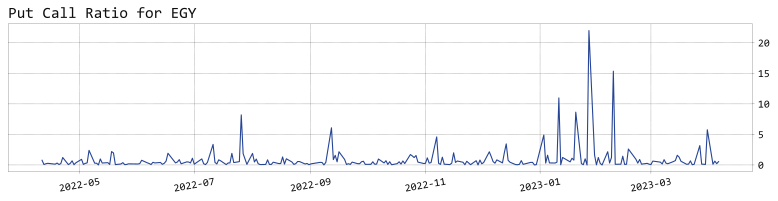

In [16]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.options.pcr_chart(
    symbol,
    window=30,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
pcr_chart = f.getvalue().decode("utf-8")

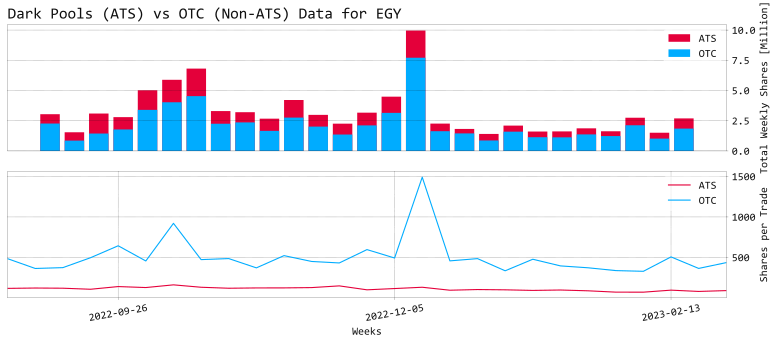

In [17]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), dpi=150)
openbb.stocks.dps.dpotc_chart(symbol=symbol, external_axes=[ax1, ax2])
fig.tight_layout()

f = io.BytesIO()
fig.savefig(f, format="svg")
dark_pools = f.getvalue().decode("utf-8")

No recent congress trading data found

No congress trading data found

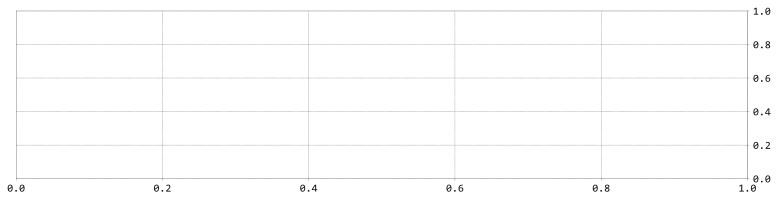

In [18]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.gov.gtrades_chart(
    symbol,
    past_transactions_months=12,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
gtrades_chart = f.getvalue().decode("utf-8")

No government contracts found

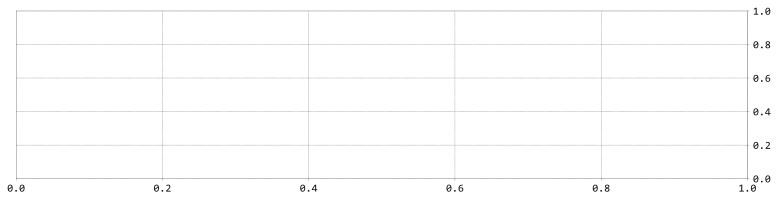

In [19]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.gov.contracts_chart(
    symbol,
    past_transaction_days=365,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
gov_contracts_chart = f.getvalue().decode("utf-8")

Too many requests: You have reached your quota limit. Please try again later.

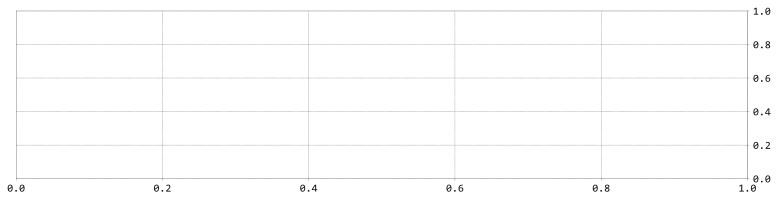

In [20]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.ba.mentions_chart(
    symbol,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
google_mentions_chart = f.getvalue().decode("utf-8")

Too many requests: You have reached your quota limit. Please try again later.

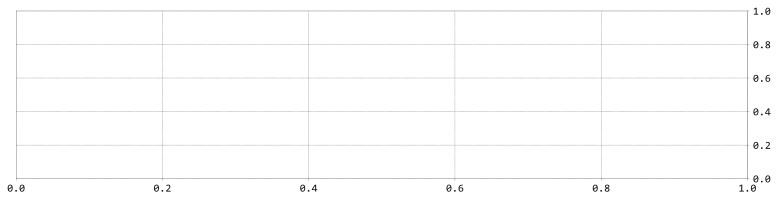

In [21]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.ba.regions_chart(
    symbol,
    limit=10,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
google_regions_chart = f.getvalue().decode("utf-8")


4 Failed downloads:
- QEP: No timezone found, symbol may be delisted
- NBL: No timezone found, symbol may be delisted
- TAT: No timezone found, symbol may be delisted
- ZN: No timezone found, symbol may be delisted


NaN values found in: ZN, NBL, QEP, TAT.  Backfilling data

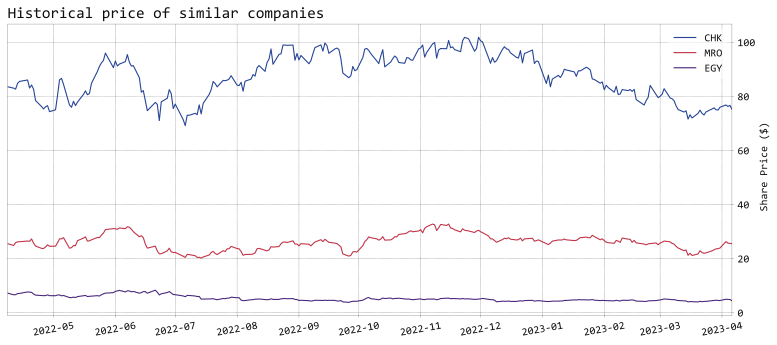

In [22]:

                    
                        
if (symbol in similar_companies_dict):
    similar_companies = similar_companies_dict[symbol]
else:
    similar_companies=openbb.stocks.ca.similar(symbol,source="Polygon")

similar_companies.append(symbol)
fig, ax = plt.subplots(figsize=(11, 5), dpi=150)
openbb.stocks.ca.hist_chart(
    similar_companies,
    external_axes=[
        ax,
    ],
    normalize=False,
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
historical_similar = f.getvalue().decode("utf-8")

In [23]:
df_historical_ratios=openbb.stocks.fa.ratios(symbol=symbol,quarterly=True,limit=16)
df_historical_ratios

Fiscal Date Ending,2022-09,2022-06,2022-03,2021-12,2021-09,2021-06,2021-03,2020-12,2020-09,2020-06,2020-03,2019-12,2019-09,2019-06,2019-03,2018-12
Period,Q3,Q2,Q1,Q4,Q3,Q2,Q1,Q4,Q3,Q2,Q1,Q4,Q3,Q2,Q1,Q4
Current ratio,0.862,0.951,0.819,1.048,1.012,0.868,0.757,1.217,1.438,1.232,1.203,1.094,1.278,1.483,1.434,1.432
Quick ratio,0.525,0.817,0.672,0.967,0.885,0.757,0.664,1.061,1.303,1.126,0.964,1.011,1.131,1.353,1.303,1.160
Cash ratio,0.485,0.322,0.161,0.578,0.835,0.335,0.296,0.910,1.110,0.888,0.928,0.720,0.981,1.030,1.068,0.813
Days of inventory outstanding,42.716,24.864,13.043,3.934,5.718,9.865,2.821,36.977,5.057,4.329,22.027,6.407,5.013,3.205,9.154,4.476
Days of payables outstanding,304.010,34.338,29.580,46.419,18.865,17.606,34.823,157.999,30.445,46.949,84.369,95.015,43.069,46.464,29.993,46.092
Effective tax rate,0.768,0.754,-0.613,-0.463,-1.180,0.323,0.238,0.182,-0.569,1.352,-1.738,0.802,2.009,1.104,0.768,0.519
Return on assets,0.017,0.041,0.039,0.131,0.154,0.032,0.056,-0.025,0.056,0.004,-0.313,0.005,-0.019,-0.005,0.032,0.063
Return on equity,0.040,0.090,0.079,0.238,0.289,0.076,0.138,-0.058,0.118,0.011,-0.936,0.009,-0.036,-0.009,0.056,0.095
Return on capital employed,0.135,0.357,0.209,0.145,0.140,0.167,0.128,-0.048,0.048,-0.010,-0.259,0.053,0.010,0.041,0.035,0.121


In [24]:
df_historical_metrics=openbb.stocks.fa.metrics(symbol=symbol,quarterly=True,limit=16)
df_historical_metrics

Fiscal Date Ending,2022-09,2022-06,2022-03,2021-12,2021-09,2021-06,2021-03,2020-12,2020-09,2020-06,2020-03,2019-12,2019-09,2019-06,2019-03,2018-12
Period,Q3,Q2,Q1,Q4,Q3,Q2,Q1,Q4,Q3,Q2,Q1,Q4,Q3,Q2,Q1,Q4
Revenue per share,0,2.164,1.322,1.112,1.092,0.915,0.792,0.249,0.365,0.362,0.368,0.430,0.342,0.485,0.378,0.536
Net income per share,0.116,0.256,0.207,0.586,0.541,0.101,0.171,-0.063,0.133,0.010,-0.911,0.017,-0.066,-0.017,0.109,0.175
Operating cash flow per share,1.027,1.184,-0.013,0.058,0.573,0.197,0.030,0.146,-0.021,-0.129,0.477,-0.044,0.212,0.052,0.226,0.019
Free cash flow per share,0.290,0.554,-0.407,-0.080,0.502,0.063,-0.300,0.111,-0.059,-0.270,0.270,-0.164,0.174,0.046,0.213,0.004
Cash per share,1.173,0.901,0.323,0.830,0.902,0.394,0.334,0.832,0.731,0.780,1.052,0.789,0.971,0.812,0.775,0.560
Book value per share,2.940,2.854,2.636,2.462,1.870,1.335,1.242,1.069,1.126,0.987,0.973,1.885,1.864,1.934,1.950,1.844
Tangible book value per share,2.940,2.854,2.636,2.462,1.870,1.335,1.242,1.069,1.126,0.987,0.973,1.885,1.864,1.934,1.950,1.844
Shareholders equity per share,2.940,2.854,2.636,2.462,1.870,1.335,1.242,1.069,1.126,0.987,0.973,1.885,1.864,1.934,1.950,1.844
Interest debt per share,0.060,0.085,0.147,0.175,0.222,0.280,0.338,0.392,0.448,0.486,0.527,0.576,0.628,0.574,0.617,-0.001



4 Failed downloads:
- QEP: No timezone found, symbol may be delisted
- NBL: No timezone found, symbol may be delisted
- TAT: No timezone found, symbol may be delisted
- ZN: No timezone found, symbol may be delisted


NaN values found in: ZN, NBL, QEP, TAT.  Backfilling data

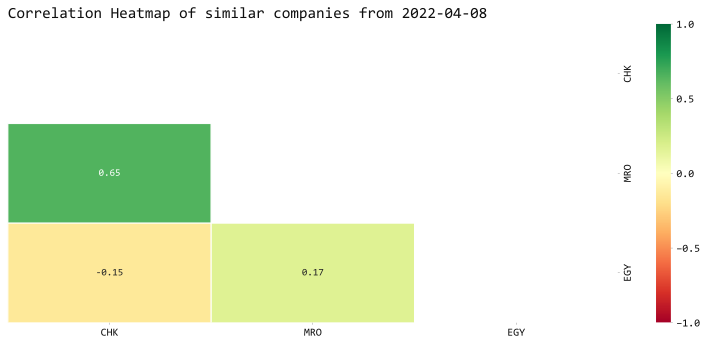

In [25]:
fig, ax = plt.subplots(figsize=(11, 5), dpi=150)
openbb.stocks.ca.hcorr_chart(
    similar_companies,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
hcorr_similar = f.getvalue().decode("utf-8")


4 Failed downloads:
- QEP: No timezone found, symbol may be delisted
- NBL: No timezone found, symbol may be delisted
- TAT: No timezone found, symbol may be delisted
- ZN: No timezone found, symbol may be delisted


NaN values found in: ZN, NBL, QEP, TAT.  Backfilling data

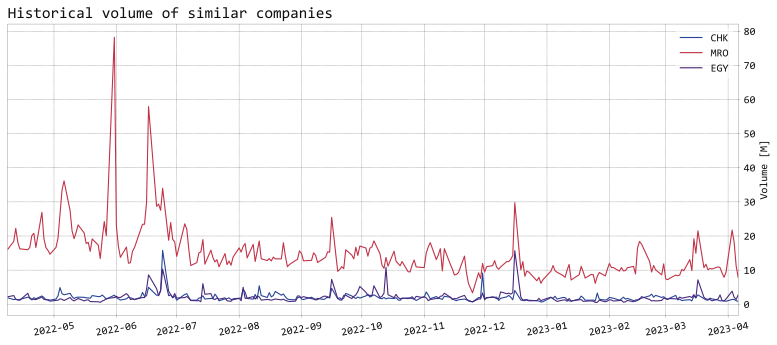

In [26]:
fig, ax = plt.subplots(figsize=(11, 5), dpi=150)
openbb.stocks.ca.volume_chart(
    similar_companies,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
vol_similar = f.getvalue().decode("utf-8")

Request error in retrieving TAT sentiment from FinBrain API

Unexpected data format or no data from FinBrain API for ZN

Unexpected data format or no data from FinBrain API for NBL

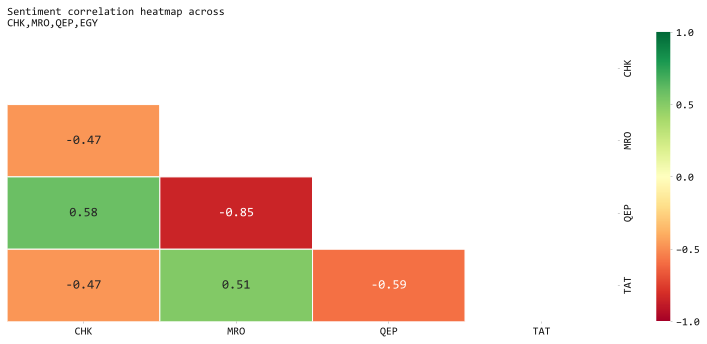

In [27]:
fig, ax = plt.subplots(figsize=(11, 5), dpi=150)
openbb.stocks.ca.scorr_chart(
    similar_companies,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
scorr_similar = f.getvalue().decode("utf-8")

In [28]:
valuation_comparison = openbb.stocks.ca.screener(similar_companies, "valuation")
valuation_comparison = valuation_comparison.drop(columns=['Change', 'Volume', 'Price', 'EPS next 5Y', 'PEG', 'Sales past 5Y'])
valuation_comparison['Market Cap']=valuation_comparison['Market Cap'].apply(lambda x: "${0:.0f} M".format(x/1000000))

valuation_comparison = valuation_comparison.style.format({"EPS this Y": "${:,.2f}", "EPS next Y": "${:,.2f}", "EPS past 5Y": "${:,.2f}", 
                                                          "P/E": "{:,.2f}", "Fwd P/E":"{:,.2f}", "P/S": "{:,.2f}" , "P/B": "{:,.2f}" , 
                                                          "P/C":"{:,.2f}", "P/FCF": "{:,.2f}"} 
                                                        )
                                                      
#valuation_comparison['EPS this Y']=valuation_comparison['EPS this Y'].apply(lambda x: "${:,.2f}".format(x))

valuation_comparison

,Ticker,Market Cap,P/E,Fwd P/E,P/S,P/B,P/C,P/FCF,EPS this Y,EPS next Y,EPS past 5Y
0,CHK,$10340 M,2.38,9.78,0.90,1.11,79.51,9.48,$-0.39,$0.40,$0.17
1,EGY,$532 M,7.71,4.27,1.50,1.51,7.68,17.98,$2.67,$-0.44,$0.45
2,MRO,$16180 M,4.92,6.16,2.00,1.43,48.45,4.31,$3.38,$0.24,$0.48


In [29]:
financial_comparison = openbb.stocks.ca.screener(similar_companies, "financial")
financial_comparison = financial_comparison.drop(columns=['Change', 'Volume', 'Earnings', 'Price','Market Cap'])
financial_comparison['Dividend']=financial_comparison['Dividend'].apply(lambda x: "{0:.1f}%".format(x*100))
financial_comparison['ROA']=financial_comparison['ROA'].apply(lambda x: "{0:.1f}%".format(x*100))
financial_comparison['ROE']=financial_comparison['ROE'].apply(lambda x: "{0:.1f}%".format(x*100))
financial_comparison['ROI']=financial_comparison['ROI'].apply(lambda x: "{0:.1f}%".format(x*100))
financial_comparison['Gross M']=financial_comparison['Gross M'].apply(lambda x: "{0:.1f}%".format(x*100))
financial_comparison['Oper M']=financial_comparison['Oper M'].apply(lambda x: "{0:.1f}%".format(x*100))
financial_comparison['Profit M']=financial_comparison['Profit M'].apply(lambda x: "{0:.1f}%".format(x*100))
financial_comparison= financial_comparison.fillna("")
#financial_comparison = financial_comparison.rename(columns={'Gross M': 'Gross Margin', 'Oper M': 'Operating Margin', 'Profit M': 'Profit Margin'})
financial_comparison

,Ticker,Dividend,ROA,ROE,ROI,Curr R,Quick R,LTDebt/Eq,Debt/Eq,Gross M,Oper M,Profit M
0,CHK,12.1%,34.3%,73.0%,41.4%,1.0,1.0,0.34,0.34,84.5%,33.0%,42.6%
1,EGY,5.6%,28.0%,58.3%,70.2%,0.9,0.8,0.01,0.01,71.5%,44.9%,26.3%
2,MRO,1.6%,19.5%,31.8%,21.8%,0.7,0.7,0.49,0.52,91.5%,48.9%,44.7%


In [30]:
ownership_comparison = openbb.stocks.ca.screener(similar_companies, "ownership")
ownership_comparison = ownership_comparison.drop(columns=['Market Cap', 'Change', 'Volume', 'Avg Volume', 'Price'])
ownership_comparison= ownership_comparison.fillna("")
ownership_comparison

,Ticker,Outstanding,Float,Insider Own,Insider Trans,Inst Own,Inst Trans,Float Short,Short Ratio
0,CHK,134370000.0,128400000.0,0.001,0.0000,0.983,-0.0268,0.0673,5.38
1,EGY,107930000.0,104950000.0,0.006,-0.0111,0.332,-0.0226,0.0567,4.02
2,MRO,637000000.0,626670000.0,0.002,-0.3036,0.793,-0.0559,0.0275,1.59


In [31]:
performance_comparison = openbb.stocks.ca.screener(similar_companies, "performance")
performance_comparison = performance_comparison.drop(columns=['Rel Volume', 'Avg Volume', 'Price','Change','Volume'])
performance_comparison['Perf Week']=performance_comparison['Perf Week'].apply(lambda x: "{0:.1f}%".format(x*100))
performance_comparison['Perf Month']=performance_comparison['Perf Month'].apply(lambda x: "{0:.1f}%".format(x*100))
performance_comparison['Perf Quart']=performance_comparison['Perf Quart'].apply(lambda x: "{0:.1f}%".format(x*100))
performance_comparison['Perf Half']=performance_comparison['Perf Half'].apply(lambda x: "{0:.1f}%".format(x*100))
performance_comparison['Perf Year']=performance_comparison['Perf Year'].apply(lambda x: "{0:.1f}%".format(x*100))
performance_comparison['Perf YTD']=performance_comparison['Perf YTD'].apply(lambda x: "{0:.1f}%".format(x*100))
performance_comparison= performance_comparison.fillna("")
performance_comparison

,Ticker,Perf Week,Perf Month,Perf Quart,Perf Half,Perf Year,Perf YTD,Volatility W,Volatility M,Recom
0,CHK,0.4%,-4.0%,-10.5%,-23.9%,-8.6%,-19.5%,0.0289,0.0336,1.9
1,EGY,-2.4%,-10.3%,4.2%,-20.3%,-37.3%,-2.6%,0.0622,0.0617,1.5
2,MRO,7.6%,0.5%,-1.4%,-6.1%,2.9%,-5.7%,0.0292,0.0406,2.2


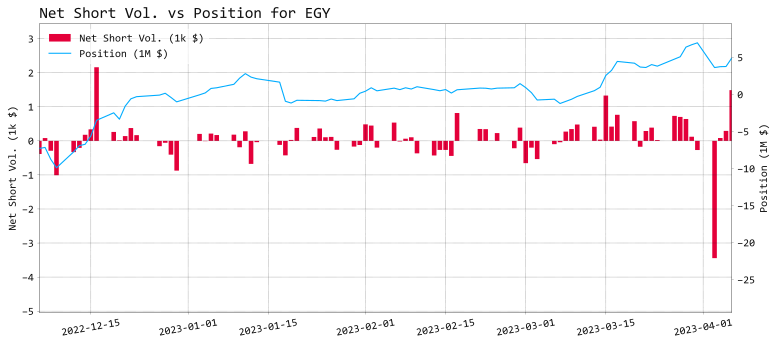

In [32]:
fig, ax1 = plt.subplots(figsize=(11, 5), dpi=150)
ax2 = ax1.twinx()
openbb.stocks.dps.spos_chart(
    symbol=symbol,
    limit=84,
    raw=False,
    export="",
    external_axes=[ax1, ax2],
)
fig.tight_layout()

f = io.BytesIO()
fig.savefig(f, format="svg")
net_short_position = f.getvalue().decode("utf-8")

In [33]:
try:
    df_related_queries = openbb.stocks.ba.queries(symbol)
    df_related_queries.index += 1
    df_related_queries.index
except:
    pass

Too many requests: You have reached your quota limit. Please try again later.

In [34]:
try:
    df_rising_queries = openbb.stocks.ba.rise(symbol)
    df_rising_queries.index += 1
    df_rising_queries
except:
    pass

Too many requests: You have reached your quota limit. Please try again later.

No quarterly government contracts found

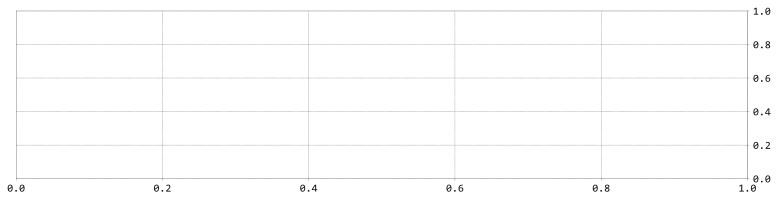

In [35]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.gov.histcont_chart(
    symbol,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
gov_histcont_chart = f.getvalue().decode("utf-8")

In [36]:
df_lobbying = openbb.stocks.gov.lobbying(symbol, limit=5)
df_lobbying

No corporate lobbying found

""


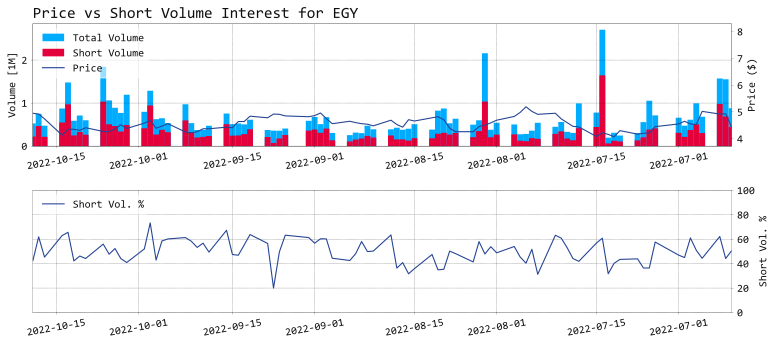

In [37]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), dpi=150)
ax3 = ax1.twinx()
openbb.stocks.dps.psi_sg_chart(
    symbol=symbol,
    external_axes=[ax1, ax2, ax3],
)
fig.tight_layout()

f = io.BytesIO()
fig.savefig(f, format="svg")
price_vs_short_interest = f.getvalue().decode("utf-8")

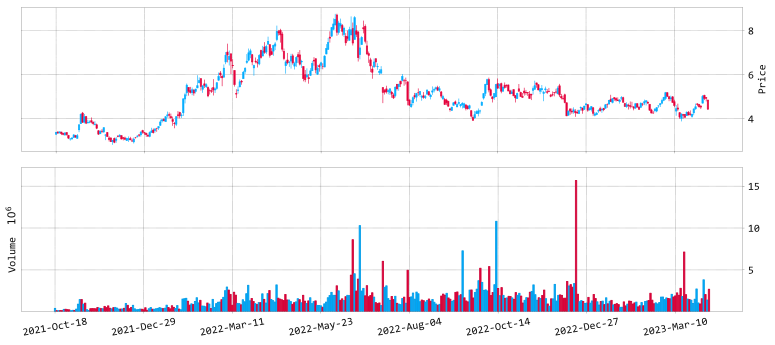

In [38]:
fig, (candles, volume) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), dpi=150)
openbb.stocks.candle(
    symbol=symbol,
    data=ticker_data,
    use_matplotlib=True,
    external_axes=[candles, volume],
)
candles.set_xticklabels("")
fig.tight_layout()

f = io.BytesIO()
fig.savefig(f, format="svg")
price_chart = f.getvalue().decode("utf-8")

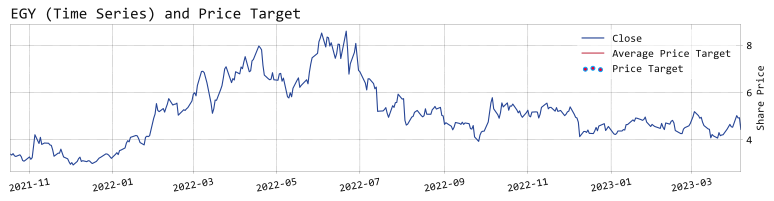

In [39]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.dd.pt_chart(
    symbol=symbol,
    start_date="2022-01-01",
    data=ticker_data,
    limit=10,
    raw=False,
    external_axes=[ax],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
price_target_chart = f.getvalue().decode("utf-8")

In [40]:
df = openbb.stocks.dd.pt(symbol=symbol)
avg_ratings_last_30_days = 0
days = 0
if not df.empty:
    df_ratings = df[datetime.datetime.now() - datetime.timedelta(days=days) :]
    while df_ratings.empty:
        days += 30
        df_ratings = df[datetime.datetime.now() - datetime.timedelta(days=days) :]

        if days > 100:
            break

    if not df_ratings.empty:
        avg_ratings_last_30_days = round(np.mean(df_ratings["Price Target"].values), 2)
    else:
        avg_ratings = 0

last_price = round(ticker_data["Close"][-1], 2)

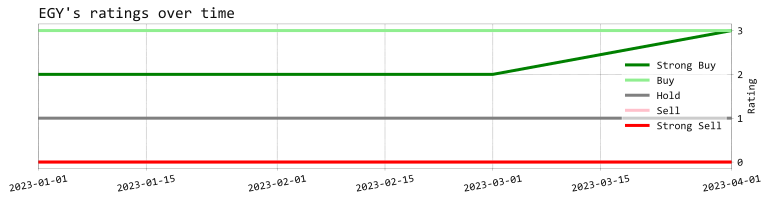

In [41]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.dd.rot_chart(
    symbol=symbol,
    limit=10,
    raw=False,
    export="",
    external_axes=[ax],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
ratings_over_time_chart = f.getvalue().decode("utf-8")

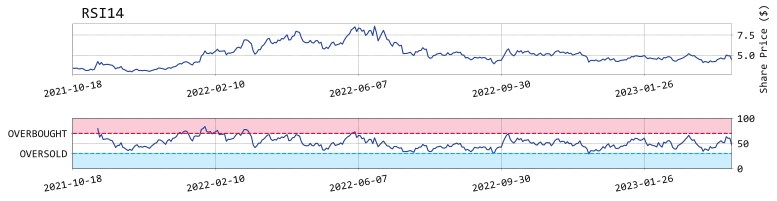

In [42]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(11, 3), dpi=150)
openbb.ta.rsi_chart(ticker_data["Close"], external_axes=[ax1, ax2])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
ta_rsi = f.getvalue().decode("utf-8")

In [43]:
df = openbb.ta.rsi(ticker_data["Close"])
rsi_value = round(df.values[-1][0], 2)
rsi_value

46.81

In [44]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(
    np.array(range(len(ticker_data["Close"][-30:].index))).reshape(-1, 1),
    ticker_data["Close"][-30:].values,
)
regression_slope = round(model.coef_[0], 2)

In [45]:
import pandas as pd

df_insider = pd.DataFrame.from_dict(openbb.stocks.ins.lins(symbol=symbol)).head(10)
if (df_insider.empty):
    print("empty")
    last_10_insider_trading = 0
else:
    df_insider["Val ($)"] = df_insider["Value ($)"].replace({",": ""}, regex=True)
    df_insider["Trade"] = df_insider.apply(
        lambda row: (-1 * float(row["Val ($)"]))
        if row["Transaction"] == "Sale"
        else (float(row["Val ($)"]) if row["Transaction"] == "Buy" else 0),
        axis=1,
    )
    last_10_insider_trading = round(sum(df_insider["Trade"]) / 1_000_000, 2)
    df_insider = df_insider.drop(columns=["Val ($)", "Trade"])
    df_insider

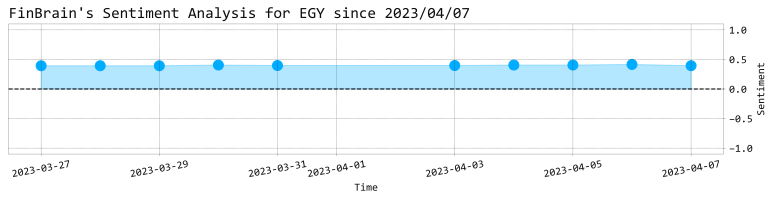

In [46]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.ba.headlines_chart(symbol=symbol, external_axes=[ax])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
finbrain_sentiment = f.getvalue().decode("utf-8")

In [47]:
df_sentiment_finbrain = openbb.stocks.ca.sentiment(symbols=[symbol])
# comment out
#finbrain_sentiment_val = float(df_sentiment_finbrain.values[-1][0])
finbrain_sentiment_val = 0

In [48]:
(
    watchlist_count,
    n_cases,
    n_bull,
    n_bear,
) = openbb.stocks.ba.bullbear(symbol=symbol)
stocktwits_sentiment = f"Watchlist count: {watchlist_count}</br>"
if n_cases > 0:
    stocktwits_sentiment += f"\nLast {n_cases} sentiment messages:</br>"
    stocktwits_sentiment += f"Bullish {round(100*n_bull/n_cases, 2)}%</br>"
    stocktwits_sentiment += f"Bearish {round(100*n_bear/n_cases, 2)}%"
else:
    stocktwits_sentiment += "No messages found"
stocktwits_sentiment

'Watchlist count: 3853</br>\nLast 3 sentiment messages:</br>Bullish 100.0%</br>Bearish 0.0%'

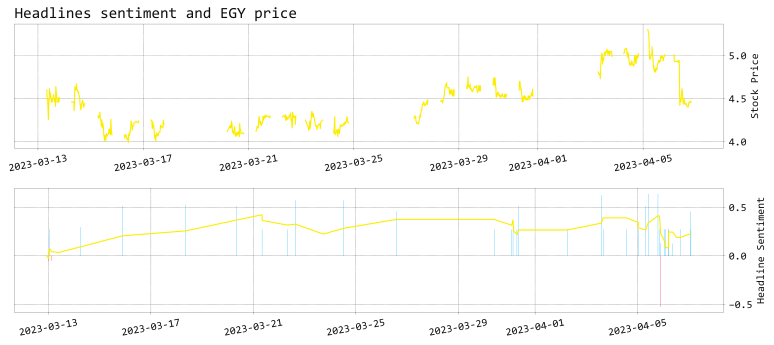

In [49]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), dpi=150)
openbb.stocks.ba.snews_chart(symbol, external_axes=[ax1, ax2])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
snews = f.getvalue().decode("utf-8")

In [50]:
netDebtEBITDA = df_historical_metrics["2022-12"]["Net debt to EBITDA"]
pbRatio = df_historical_metrics["2022-12"]["Pb ratio"]
debtEquity = df_historical_metrics["2022-12"]["Debt to equity"]
shortRatio =ownership_comparison.loc[ownership_comparison['Ticker'] == symbol, 'Short Ratio'].values[0]
print(shortRatio)

KeyError: '2022-12'

**OpenAI**

In [ ]:

#prompt = "I want you to act like an equity analyst and give a BUY/HOLD/SELL recommendation on the following ticker that I will provide. \n " \
#         "I will also provide you with the latest financial ratios. Pay special attention to short ratio and debt levels. \n" + \
#         " Here are the rules I want you to follow to determine the recommendation:" + \
#         "Rules: \n" + \
#         "If short ratio is greater than 3 is a negative.  \n" \
#         "If the Debt to Equity to > 2 it is a negative. \n" \
#         "If price to book is < 1, it's positive  \n" \
#         "If RSI lower than 30 means oversold and suggests a potential buying opportunity \n" \
#         "Summarize in 4 paragraphs.  In the summary, start with a description of the company, how it makes money, risks to consider, financial ratios, \n" + \
#         "market sentiment, and finally the recommendation. If you don't have the financial ratio info, don't include that in the analysis \n " + \
#         "Ticker is " + symbol  + " . RSI value = " + str(rsi_value) + " Debt to Equity = " + str(debtEquity) + " . Price to book = " + str(pbRatio) + "\n" \
#         ". Latest market sentiment : positive = " + str(n_bull) + "negative = " + str(n_bear) + " Short ratio = " + str(shortRatio) + "\n" 

#response = openai.Completion.create(
#    prompt=prompt,
#    temperature=0,
#    max_tokens=1000,
#    top_p=1,
#    frequency_penalty=0,
#    presence_penalty=0,
#    engine="text-davinci-003",
#)

#openai_opinion = response.choices[0].text.strip()
#print (openai_opinion)

In [51]:
ticker_data_all = openbb.stocks.load(
    symbol=symbol,
    start_date=datetime.datetime.now() - datetime.timedelta(days=5 * 12 * 21),
)
ticker_data_all["Returns"] = ticker_data_all["Adj Close"].pct_change()

Loading Daily data for EGY with starting period 2019-10-28.

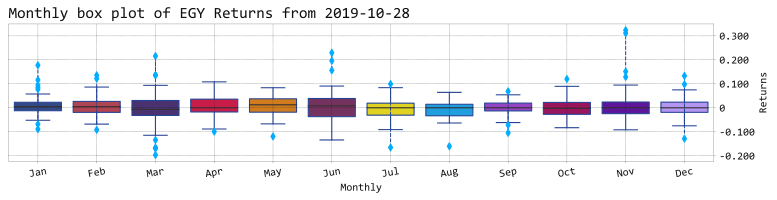

In [52]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.qa.bw(
    ticker_data_all,
    "Returns",
    symbol,
    yearly=False,
    external_axes=[ax],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
bw_month = f.getvalue().decode("utf-8")

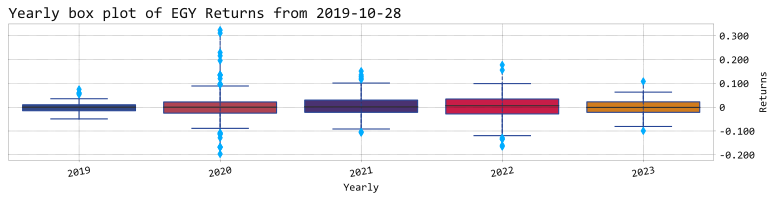

In [53]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.qa.bw(
    ticker_data_all,
    "Returns",
    symbol,
    yearly=True,
    external_axes=[ax],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
bw_year = f.getvalue().decode("utf-8")

In [54]:
income_df = openbb.stocks.fa.income(symbol, source="YahooFinance")
income_df = income_df/1000000
income_df = income_df.applymap("${0:.0f}M".format)

mgmt_df = openbb.stocks.fa.mgmt(symbol)
if (mgmt_df.empty):
    print ("empty")
else:
    mgmt_df["Info"] = mgmt_df["Info"].apply(lambda x: f'<a href="{x}">{x}</a>')
    mgmt_df["Insider Activity"] = mgmt_df["Insider Activity"].apply(
        lambda x: f'<a href="{x}">{x}</a>' if x != "-" else x
    )
try:
    hist_dcf = openbb.stocks.fa.dcf(symbol)
except:
    pass
enterprise_df = openbb.stocks.fa.enterprise(symbol)
score = openbb.stocks.fa.score(symbol)
if score:
    score = round(float(score), 2)

No management information in Business Insider for EGY

empty


Ticker should be a NASDAQ 100 ticker or SP 500 ticker

In [55]:
hist_ratios = openbb.stocks.fa.ratios(symbol)
hist_ratios

Fiscal Date Ending,2021,2020,2019,2018,2017
Period,FY,FY,FY,FY,FY
Current ratio,1.048,1.217,1.094,1.432,0.782
Quick ratio,0.967,1.061,1.011,1.160,0.574
Cash ratio,0.578,0.910,0.720,0.813,0.422
Days of sales outstanding,52.500,37.335,70.026,43.349,33.413
Days of inventory outstanding,4.432,25.042,6.862,4.690,25.805
Operating cycle,56.932,62.377,76.888,48.039,59.218
Days of payables outstanding,52.301,107.004,101.756,48.297,91.610
Cash conversion cycle,4.631,-44.627,-24.867,-0.257,-32.392
Gross profit margin,0.424,0.265,0.411,0.491,0.401


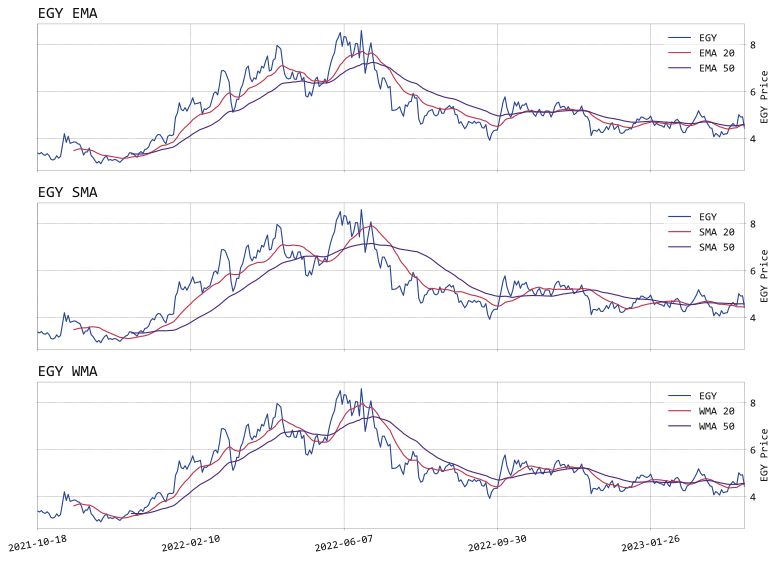

In [56]:
fig, (ax1, ax2, ax3) = plt.subplots(
    nrows=3, ncols=1, figsize=(11, 8), sharex=True, dpi=150
)
openbb.ta.ma(ticker_data["Close"], symbol=symbol, external_axes=[ax1])
openbb.ta.ma(ticker_data["Close"], symbol=symbol, ma_type="SMA", external_axes=[ax2])
openbb.ta.ma(ticker_data["Close"], symbol=symbol, ma_type="WMA", external_axes=[ax3])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
ma_chart = f.getvalue().decode("utf-8")

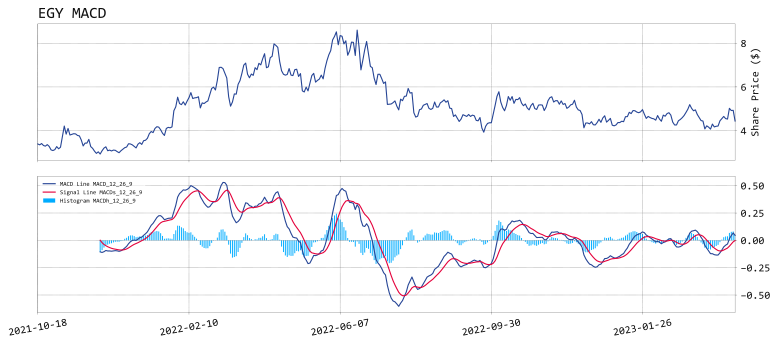

In [57]:
fig, (ax, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), sharex=True, dpi=150)
openbb.ta.macd_chart(ticker_data["Close"], symbol=symbol, external_axes=[ax, ax1])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
macd_chart = f.getvalue().decode("utf-8")

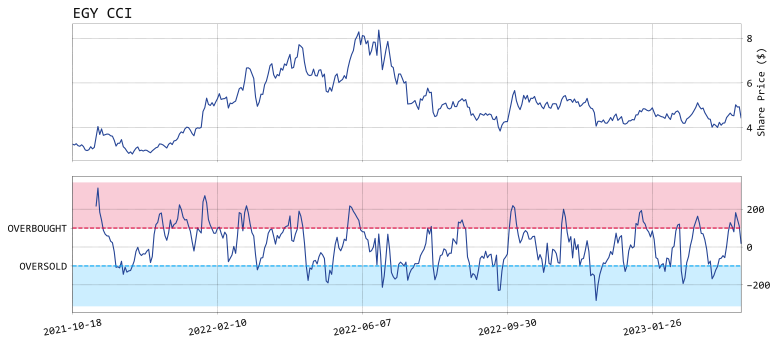

In [58]:
fig, (ax, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), sharex=True, dpi=150)
openbb.ta.cci_chart(ticker_data, symbol=symbol, external_axes=[ax, ax1])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
cci_chart = f.getvalue().decode("utf-8")

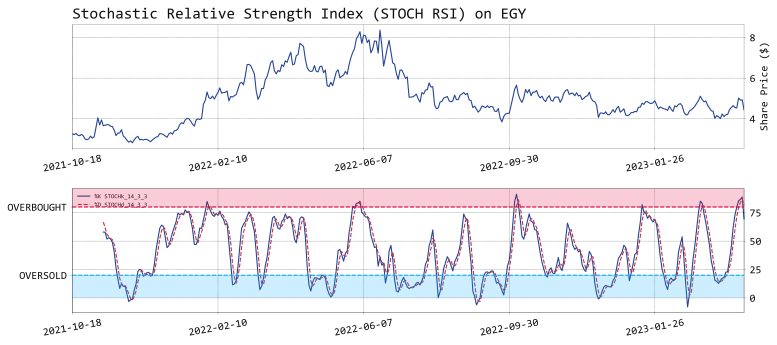

In [59]:
fig, (ax, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), dpi=150)
ax2 = ax1.twinx()
openbb.ta.stoch_chart(ticker_data, symbol=symbol, external_axes=[ax, ax1, ax2])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
stoch_chart = f.getvalue().decode("utf-8")

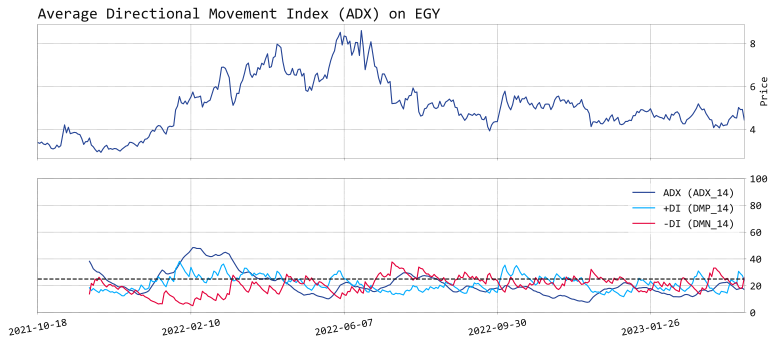

In [60]:
fig, (ax, ax1) = plt.subplots(2, 1, sharex=True, figsize=(11, 5), dpi=150)
openbb.ta.adx_chart(ticker_data, symbol=symbol, external_axes=[ax, ax1])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
adx_chart = f.getvalue().decode("utf-8")

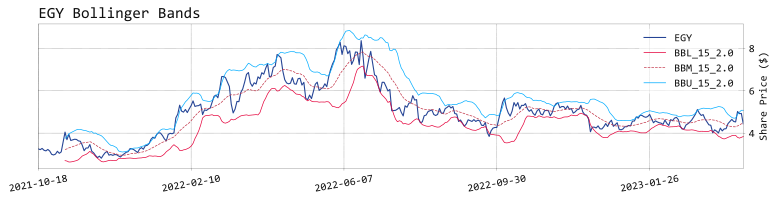

In [61]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.ta.bbands_chart(ticker_data, symbol=symbol, external_axes=[ax])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
bbands_chart = f.getvalue().decode("utf-8")

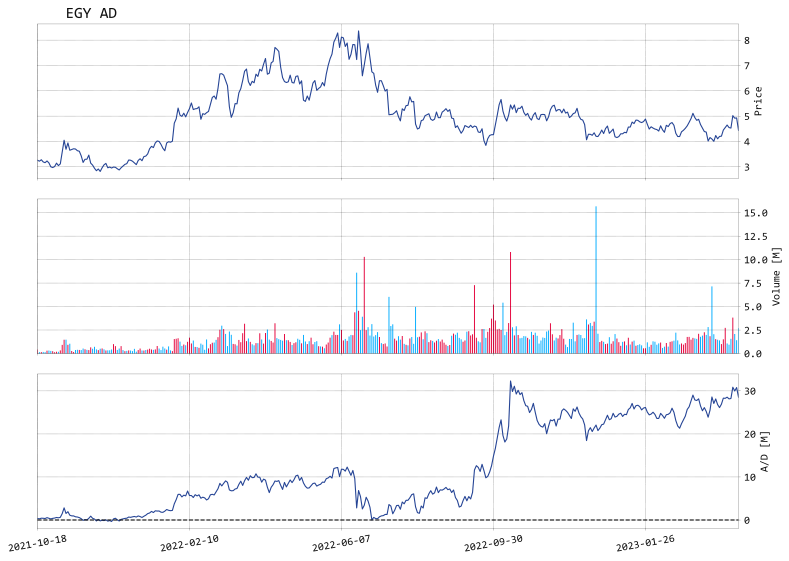

In [62]:
fig, (ax, ax1, ax2) = plt.subplots(3, 1, sharex=True, figsize=(11, 8), dpi=150)
openbb.ta.ad_chart(ticker_data, symbol=symbol, external_axes=[ax, ax1, ax2])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
ad_chart = f.getvalue().decode("utf-8")

## Render the report template to a file

In [69]:
body =""
    
img = (
    str(REPOSITORY_DIRECTORY)
    + "/openbb_terminal/reports/templates/OpenBB_reports_logo.png"
)
floppy_disk_img = (
    str(REPOSITORY_DIRECTORY) + "/openbb_terminal/reports/templates/floppy-disc.png"
)

htmlcode = ""
if (not investor_report_url):
    htmlcode = f"""
    <div class="hcontainer">
        <div class="item">
            <!-- TradingView Widget BEGIN -->
                <div class="tradingview-widget-container">
                    <div class="tradingview-widget-container__widget"></div>
                    <div class="tradingview-widget-copyright"><a href="https://www.tradingview.com/symbols/NYSE-{symbol}/" rel="noopener" target="_blank"><span class="blue-text">AR key facts</span></a> by TradingView</div>
                    <script type="text/javascript" src="https://s3.tradingview.com/external-embedding/embed-widget-symbol-profile.js" async>
                    {{
                    "width": "1085",
                    "height": "500",
                    "colorTheme": "light",
                    "isTransparent": false,
                    "symbol": "{exchange}:{symbol}",
                    "locale": "en"
                    }}
                    </script>
                </div>
            <!-- TradingView Widget END -->
        </div>
    </div>
    """

if (investor_report_url): 
    htmlcode += widgets.row([widgets.h(3, "Investor Presentation for " + symbol)])
    htmlcode += f"""
        <div class="hcontainer">
            <div class="item">
                <iframe src="{investor_report_url}" width="1085" height="700"></iframe>
            </div>
        </div>
            """

            
body += widgets.add_tab("Summary", htmlcode, False)

htmlcode = f"""
<div class="hcontainer">
    <div class="item">
        <!-- TradingView Widget BEGIN -->
        <div class="tradingview-widget-container">
        <div id="tradingview_fceac"></div>
        <div class="tradingview-widget-copyright"><a href="https://www.tradingview.com/symbols/{exchange}-{symbol}/" rel="noopener" target="_blank"><span class="blue-text">AR stock price</span></a> by TradingView</div>
        <script type="text/javascript" src="https://s3.tradingview.com/tv.js"></script>
        <script type="text/javascript">
        new TradingView.MediumWidget(
            {{
            "symbols": [
                [
                "{long_name}",
                "{exchange}:{symbol}|1D"
                ]
            ],
            "chartOnly": false,
            "width": "1085",
            "height": "700",
            "locale": "en",
            "colorTheme": "light",
            "autosize": false,
            "showVolume": false,
            "hideDateRanges": false,
            "hideMarketStatus": false,
            "scalePosition": "right",
            "scaleMode": "Normal",
            "fontFamily": "-apple-system, BlinkMacSystemFont, Trebuchet MS, Roboto, Ubuntu, sans-serif",
            "fontSize": "10",
            "noTimeScale": false,
            "valuesTracking": "1",
            "chartType": "line",
            "container_id": "tradingview_fceac"
            }}
        );
        </script>
        </div>
        <!-- TradingView Widget END -->
    </div>
</div>
"""
#htmlcode += widgets.row([widgets.p(openai_opinion)])

body += widgets.add_tab("Overview", htmlcode, False)

htmlcode = widgets.row([widgets.h(3, "Latest News for " + symbol)])
try:
    for table in tables:
        htmlcode += widgets.row(
            [widgets.h(4, table[1]["title"]) + table[0].to_html(escape=False)]
        )
except:
    pass

htmlcode += widgets.row([widgets.h(3, "Twitter News for " + symbol )])

htmlcode += """
<div class="hcontainer">
    <div class="item">
        <div class="tweet-list">
            {% for tweet in tweets %}
            <div class="tweet">
                <div class="tweet-header">
                    <img src="{{ tweet.user.profile_image_url }}" alt="{{ tweet.user.name }}'s profile picture">
                    <h3>{{ tweet.user.name }}</h3>                   
                </div>       
                <div class="tweet-body">
                    <p>{{ tweet.full_text }}</p>
                </div>   
                {% if tweet.entities.media %}
                    <div class="tweet-media">
                    {% for media in tweet.entities.media %}
                        <img src="{{ media.media_url_https }}" alt="Tweet media">
                    {% endfor %}
                    </div>
                {% endif %}
                <div class="tweet-footer">
                    {% set date = tweet.created_at.strftime('%b %d, %Y at %I:%M %p') %}
                    <p>{{ date }}</p>
                    <a href="https://twitter.com/{{ tweet.user.screen_name }}/status/{{ tweet.id }}" target="_blank">View on Twitter</a>
                </div>
            </div>
            {% endfor %}
        </div>
    </div>
</div>
        """

body += widgets.add_tab("News and Twitter", htmlcode, False)

if(morningstar_report_url):
    htmlcode = widgets.row([widgets.h(3, "Morningstar analysis " + symbol)])
    htmlcode += f"""
            <div class="hcontainer">
                <div class="item">
                <iframe src="{morningstar_report_url}" width="1085" height="700" allow="autoplay"></iframe>
                </div>
            </div>
                """
else:
    htmlcode = widgets.row([widgets.h(3, "Morningstar analysis not available ")])

htmlcode += widgets.row([widgets.h(3, "Price Target Chart") + price_target_chart])
htmlcode += widgets.row(
    [widgets.h(3, "Analyst Ratings over time") + ratings_over_time_chart]
)
try:
    htmlcode += widgets.row([widgets.h(3, "Analyst Ratings") + df_analyst.to_html()])
except:
    pass
try:
    htmlcode += widgets.row(
        [widgets.h(3, "Analyst Recommendations") + df_rating.head(15).to_html()]
    )
except:
    pass

body += widgets.add_tab("Analyst Opinions", htmlcode, False)

htmlcode = f"""
<div class="hcontainer">
        <div class="item">
        <!-- TradingView Widget BEGIN -->
            <div class="tradingview-widget-container">
                <div class="tradingview-widget-container__widget"></div>
                <div class="tradingview-widget-copyright"><a href="https://www.tradingview.com/symbols/{exchange}-{symbol}/financials-overview/" rel="noopener" target="_blank"><span class="blue-text">AR fundamentals</span></a> by TradingView</div>
                <script type="text/javascript" src="https://s3.tradingview.com/external-embedding/embed-widget-financials.js" async>
                {{
                "colorTheme": "light",
                "isTransparent": false,
                "largeChartUrl": "",
                "displayMode": "regular",
                "width": "1085",
                "height": "800",
                "symbol": "{exchange}:{symbol}",
                "locale": "en"
                }}
                </script>
            </div>
        <!-- TradingView Widget END -->
    </div>
</div>
"""

#try:
#    htmlcode += widgets.row(
#        [widgets.h(3, "Shares outstanding ") + shares_outstanding_chart]
#    )
#except:
#    pass

try:
    htmlcode += widgets.row(
        [widgets.h(3, "Estimates") + df_year_estimates.head().to_html()]
    )
except:
    pass

htmlcode += widgets.row(
    [widgets.h(3, "Earnings") + df_quarter_earnings.head().to_html()]
)
htmlcode += widgets.row(
    [widgets.h(3, "Revenues") + df_quarter_revenues.head().to_html()]
)
try:
    htmlcode += widgets.row(
        [
            widgets.h(3, "Major Institutional Shareholders")
            + df_institutional_shareholders.head().to_html()
        ]
    )
except:
    pass
try:
    htmlcode += widgets.row(
        [widgets.h(3, f"Historical DCF for {symbol}") + hist_dcf.to_html()]
    )
except:
    pass
htmlcode += widgets.row(
    [widgets.h(3, f"Enterprise data for {symbol}") + enterprise_df.to_html()]
)
htmlcode += widgets.row(
    [widgets.h(3, f"Income Statement for {symbol}") + income_df.to_html()]
)
try:
    htmlcode += widgets.row([widgets.h(3, f"Data for {symbol}") + data_df.to_html()])
except:
    pass
try:
    htmlcode += widgets.row(
        [widgets.h(3, "SEC filings") + df_sec_filings.to_html(escape=False)]
    )
except:
    pass

htmlcode += widgets.row([widgets.h(3, "Ratios") + hist_ratios.to_html(escape=False)])

body += widgets.add_tab("Fundamental Analysis", htmlcode, False)

htmlcode = widgets.row([widgets.h(3, "Put to call ratio") + pcr_chart])
#if not option_chain.empty:
#    htmlcode += widgets.row(
#        [widgets.h(3, "Option Volume for closest expiry date") + vol_chart]
#    )
#    htmlcode += widgets.row(
#        [widgets.h(3, "Volume and Open Interest for closest expiry date") + voi_chart]
#    )
#try:
#    htmlcode += widgets.row([widgets.h(3, "Option Chains") + options_df.to_html()])
#except:
#    pass
body += widgets.add_tab("Options", htmlcode, False)

htmlcode = widgets.row([net_short_position])
htmlcode += widgets.row([price_vs_short_interest])
body += widgets.add_tab("Shorts", htmlcode, False)

htmlcode = widgets.row(
    [widgets.h(3, "Strong ROIC and Operating Margins are signal of presence of moat")]
)

#htmlcode = widgets.row(
#    [
#        widgets.h(3, f"Return on invested capital for companies similar to {symbol}")
#        + roic_chart
#   ]
#)

#htmlcode += widgets.row(
#    [
#        widgets.h(3, f"Free Cash Flow Yield of companies similar to {symbol}")
#        + fcf_yield_chart
#    ]
#)

#htmlcode += widgets.row(
#        [
#        widgets.h(3, f"Payout ratio for companies similar to {symbol}")
#        + payout_ratio_chart
#    ]
#)

htmlcode += widgets.row(
    [
        widgets.h(3, f"Price over the past year for companies similar to {symbol}")
        + historical_similar
    ]
)
htmlcode += widgets.row(
    [
        widgets.h(3, f"Price correlation with similar companies for {symbol}")
        + hcorr_similar
    ]
)
htmlcode += widgets.row(
    [
        widgets.h(3, f"Volume over the past year for companies similar to {symbol}")
        + vol_similar
    ]
)
htmlcode += widgets.row(
    [
        widgets.h(3, f"Sentiment correlation with similar companies for {symbol}")
        + scorr_similar
    ]
)

try:
    htmlcode += widgets.row([widgets.h(3, "Valuation Comparison") + valuation_comparison.to_html()])
except:
    pass

try:
    htmlcode += widgets.row([widgets.h(3, "Financials Comparison") + financial_comparison.to_html()])
except:
    pass

try:
    htmlcode += widgets.row([widgets.h(3, "Ownership Comparison") + ownership_comparison.to_html()])
except:
    pass

try:
    htmlcode += widgets.row([widgets.h(3, "Performance Comparison") + performance_comparison.to_html()])
except:
    pass

htmlcode += widgets.row(
    [
        widgets.p(
            "Note that similar companies have been found using openbb.stocks.ca.similar"
        )
    ]
)
body += widgets.add_tab("Comparison", htmlcode, False)

htmlcode = f"""
<div class="hcontainer">
        <div class="item">
        <!-- TradingView Widget BEGIN -->
            <div class="tradingview-widget-container">
                <div class="tradingview-widget-container__widget"></div>
                <div class="tradingview-widget-copyright"><a href="https://www.tradingview.com/symbols/{exchange}-{symbol}/technicals/" rel="noopener" target="_blank"><span class="blue-text">AR stock analysis</span></a> by TradingView</div>
                <script type="text/javascript" src="https://s3.tradingview.com/external-embedding/embed-widget-technical-analysis.js" async>
                {{
                "interval": "1W",
                "width": "1085",
                "isTransparent": false,
                "height": "700",
                "symbol": "{exchange}:{symbol}",
                "showIntervalTabs": true,
                "locale": "en",
                "colorTheme": "light"
                }}
                </script>
            </div>
        <!-- TradingView Widget END -->
    </div>
</div>
        """

htmlcode += widgets.row([widgets.h(3, f"Moving Averages for {symbol}") + ma_chart])
htmlcode += widgets.row([macd_chart])
htmlcode += widgets.row([ta_rsi])
htmlcode += widgets.row([stoch_chart])
htmlcode += widgets.row([cci_chart])
htmlcode += widgets.row([ad_chart])
htmlcode += widgets.row([bbands_chart])
htmlcode += widgets.row([adx_chart])
body += widgets.add_tab("Technical Analysis", htmlcode, False)

try:
    htmlcode = widgets.row(
        [widgets.h(3, "Last Activity") + df_insider.head(10).to_html(col_space="75px")]
    )
except:
    pass
body += widgets.add_tab("Insider Trading", htmlcode, False)

htmlcode = widgets.row([bw_year])
htmlcode += widgets.row([bw_month])
body += widgets.add_tab("Quantitative Analysis", htmlcode, False)


htmlcode = widgets.row([finbrain_sentiment])
htmlcode += widgets.row([snews])
htmlcode += widgets.row(
    [
        widgets.h(3, "Interest in " + symbol + " based on google analytics")
        + google_mentions_chart
    ]
)
htmlcode += widgets.row(
    [widgets.h(3, f"Regions with highest interest in {symbol}") + google_regions_chart]
)
try:
    htmlcode += widgets.row(
        [
            widgets.h(3, f"Top queries related to {symbol}")
            + df_related_queries.to_html()
        ]
    )
    htmlcode += widgets.row(
        [
            widgets.h(3, f"Top rising queries related to {symbol}")
            + df_rising_queries.to_html()
        ]
    )
except:
    pass
htmlcode += widgets.row(
    [widgets.h(3, f"Stocktwits sentiment for {symbol}") + stocktwits_sentiment]
)
body += widgets.add_tab("Behavioural Analysis", htmlcode, False)

htmlcode = """
    <iframe src="https://docs.google.com/spreadsheets/d/e/2PACX-1vTzYPt7GjAVk-NLvYrDo5OuxcDuaRFejqZ2iT_l2Y3nkKtAgwNO809hYnZhCIxc8XGQSDuGSfc8ZsAy/pubhtml?widget=true&amp;headers=false" width="1085" height="700"></iframe>
        """

body += widgets.add_tab("GSheets", htmlcode, False)

#This code snippet was extracted from OpenBB widget_helpers.py so that the html can be modified to work with the dashboard
body += """
        <script>
        function dmenu2(evt, menu_name) {
            event.preventDefault();
            var i, tabcontent, tablinks;
            tabcontent = document.getElementsByClassName("tabcontent");
            for (i = 0; i < tabcontent.length; i++) {
                tabcontent[i].style.display = "none";
            }
            tablinks = document.getElementsByClassName("tablinks");
            for (i = 0; i < tablinks.length; i++) {
                tablinks[i].className = tablinks[i].className.replace(" active bg-gradient-primary", "");
            }

            document.getElementById(menu_name).style.display = "block";
            evt.currentTarget.className += " active bg-gradient-primary";
        }
        window.onload = function() {
            dmenu2(event, 'Summary');
        };
        </script>"""

f = open("public/templates/report.j2", "r")
template = Template(f.read())
report= template.render(title=report_name, stylesheet=stylesheet, body=body + "</html>")

# to save the results
with open("public/templates/" + report_name + ".html", "w", encoding="utf-8") as fh:
    fh.write(report)

dotenv.load_dotenv(USER_ENV_FILE)
cfg.theme = TerminalStyle(
    os.getenv("OPENBB_MPLSTYLE") or "dark",
    os.getenv("OPENBB_MPFSTYLE") or "dark",
    os.getenv("OPENBB_RICHSTYLE") or "dark",
)